In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

### Подготовка данных

In [87]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb

train_df = pd.read_csv('data/train.csv')
final_test_df = pd.read_csv('data/test.csv')

train_df = train_df.drop(columns=['x7', 'x13', 'x14'])
final_test_df = final_test_df.drop(columns=['x7', 'x13', 'x14'])

x_df = train_df.drop(columns=['index', 'y'])
y_df = train_df['y']

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(x_df, y_df, test_size = 0.2, random_state = 0)
train_data = lgb.Dataset(X_train_df, label = y_train_df)
test_data = lgb.Dataset(X_test_df, label = y_test_df, reference = train_data)

### Анализ данных

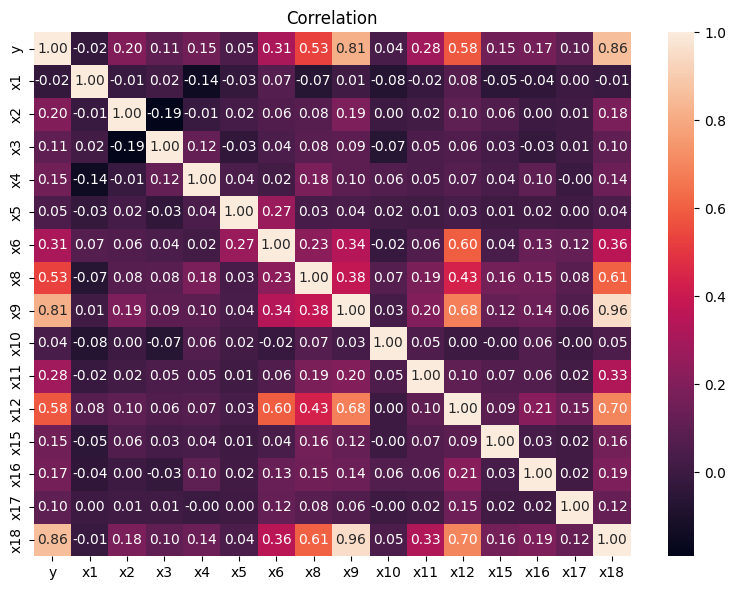

In [88]:
def print_corr(df):
    corr = df.corr()

    plt.figure(figsize = (8, 6))
    sns.heatmap(data=corr, fmt = ".2f", annot=True)
    plt.title("Correlation")
    plt.tight_layout()
    plt.show()

print_corr(train_df.drop(columns=['index']))

Из графика сразу видно, что можно выбросить x7, x13, x14 (они нули). Признаки x1, x5, x10 слабо коррелирующие.

### Выбор модели - Градиентный бустинг с оптимальными гиперпараметрами
Варьируя гиперпараметры, были получены наиболее оптимальные. На них и был получен лучший результат на `kaggle.com`.

In [89]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error

epsilon = 1e-5

def mape_loss(y_pred, data):
    y_label = data.get_label()
    grad = (y_pred - y_label) / np.maximum(epsilon, np.abs(y_label))
    hessian = 1 / np.maximum(epsilon, np.abs(y_label))
    return grad, hessian

def mape_metric(y_pred, data):
    y_label = data.get_label()
    mape = np.mean(np.abs((y_label - y_pred) / np.maximum(epsilon, np.abs(y_label))))
    return 'mape', mape, False

def get_mape(y_test, y_pred):
    return mean_absolute_percentage_error(y_test, y_pred)

params = {
    'objective': mape_loss,
    'metric': "None",
    'learning_rate': 0.025,
    'num_leaf': 30,
    'tree_learner': 'serial',
    'random_state': 0,
    'data_sample_strategy': 'goss'
}

model = lgb.train(
    params,
    train_data,
    valid_sets = [train_data, test_data],
    feval = mape_metric,
    num_boost_round = 10000,
    callbacks = [lgb.early_stopping(stopping_rounds = 100)], 
)

[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.107276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 12800, number of used features: 15
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using GOSS
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's mape: 0.239037	valid_1's mape: 0.247583


In [91]:
def make_predictions(df, model, filename):
    x_df = df.drop(["index"], axis = 1)
    y_pred = model.predict(x_df)
    prediction = pd.DataFrame({"index": df["index"], "y": y_pred})
    prediction.to_csv(filename, index=False)

make_predictions(final_test_df, model, "results1.csv")

### Итоги

В ходе работы я пробовал удалять признаки, брать различные функции от признаков, брать суперпозицию.
В целом все эти мероприятия не особо помогли получить наилучший score.